In [1]:
 #pip install gurobipy

In [2]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## function : Run Model with input data

In [ ]:
def run_model(
    scenario, 
    Lmin_t,
    Lmax_t,
    Pt_PV,
    ct_PV,
    pt,
    Emin,
    max_import_kW,
    max_export_kW,
    tau_imp,
    tau_exp,
):
    """
    Runs the optimization model for energy scheduling with PV, grid import/export, and flexible load.
    """

    # Make model
    model = gp.Model("Scenario")
    HOURS = list(range(24))

    ## deafult upper bound and lower bound of each variable
    ## TODO are bounds correct?
    lb = 0.0
    ub = float('inf')

    # one var for every t:
    # Lt: load consumption (kWh).
    Lt = {t: model.addVar(Lmin_t, Lmax_t, vtype=GRB.CONTINUOUS, name='L{0}'.format(t)) for t in HOURS}

    # ut: Energy not curtailed (kWh).
    ut= {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='s{0}'.format(t)) for t in HOURS}

    # ct: PV curtailed (kWh).
    ct = {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name='c{0}'.format(t)) for t in HOURS}

    # gt_imp : grid import (kWh).
    gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name='g{0}_imp'.format(t)) for t in HOURS}

    # gt_exp : grid export (kWh).
    gt_exp = {t: model.addVar(lb, max_export_kW, vtype=GRB.CONTINUOUS, name='g{0}_exp'.format(t)) for t in HOURS}

    model.update()
    vars = model.getVars()
    # print("added " +str(len(vars)) + " variables")

    # (Load bounds) 0 ≤ Lt ≤ Lmaxt ,
    # This has been implemented in variable definitinon, where upper and lower bound of variable have been set to Lmax_t and Lmin_t

    # (Daily minimum consumption) SUM(Lt) ≥ Emin,
    constraints = [
            (
                    model.addLConstr(
                            gp.quicksum(Lt[t] for t in HOURS),
                            GRB.GREATER_EQUAL,
                            Emin,
                            name="Daily_minimum"
                    )
            )
    ]

    # (PV allocation) ut + ct = Pt_PV
    # (Energy balance at consumer node) ut + gt_imp = Lt + gt_exp 
    for t in HOURS :
        model.addLConstr(ut[t] + ct[t], GRB.EQUAL , Pt_PV[t], name='PV_allocation')
        model.addLConstr(ut[t] + gt_imp[t], GRB.EQUAL , Lt[t] + gt_exp[t], name='Energy_balance_at_node')

    model.update()

    # Objective
    model.setObjective(
        gp.quicksum(
            (pt[t] + tau_imp) * gt_imp[t] - (pt[t] - tau_exp) * gt_exp[t]  + ct_PV*Pt_PV[t]
            for t in HOURS
        ), GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Check the optimization status
    if model.status == GRB.OPTIMAL:
        print("Optimization {i} successful!".format(i = scenario))
        # You can access the optimal objective value and variable values here
        print("Optimal objective value:", model.ObjVal)
        for v in model.getVars():
            if v.X > 1e-6: # Print only variables with non-zero values
                print(v.VarName, v.X)
    elif model.status == GRB.INFEASIBLE:
        print("Model is infeasible")
    elif model.status == GRB.UNBOUNDED:
        print("Model is unbounded")
    else:
        print("Optimization ended")

    ## 
    ## PLOT 1 : everything
    ##

    # Extract variable values from the optimization results
    Lt_values = [Lt[t].X for t in HOURS]
    ut_values = [ut[t].X for t in HOURS]
    ct_values = [ct[t].X for t in HOURS]
    gt_imp_values = [gt_imp[t].X for t in HOURS]
    gt_exp_values = [gt_exp[t].X for t in HOURS]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(HOURS, Lt_values, label='Load Consumption (Lt)', alpha=0.7, marker='o')
    plt.plot(HOURS, ut_values, label='PV not curtailed (ut)', alpha=0.7, marker='s')
    plt.plot(HOURS, ct_values, label='PV Curtailed (ct)', alpha=0.7, marker='^')
    plt.plot(HOURS, gt_imp_values, label='Grid Import (gt_imp)', alpha=0.7, marker='x')
    plt.plot(HOURS, gt_exp_values, label='Grid Export (gt_exp)', alpha=0.7, marker='D')
    plt.plot(HOURS, Pt_PV, label='PV Production (Pt_PV)', alpha=0.7, marker='*')

    # Add labels and title
    plt.xlabel('Hour')
    plt.ylabel('Value (kWh)')
    plt.title('Scenario {i}: All Decision Variable Values Over Time (vs. PV_production)'.format(i = scenario))
    plt.xticks(HOURS)
    plt.legend()
    plt.grid(True)
    plt.show()

    ##
    ## PLOT 2 : import & export behaviour
    ##

    # Create a figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot energy price on the first y-axis
    color = 'tab:red'
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
    ax1.plot(HOURS, pt, color=color, marker='o', label='Energy price(DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_imp, 24), color='tab:orange',  label='Import tariff (DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_exp, 24), color='tab:pink',  label='Export tariff (DKK/kWh)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second y-axis for import/export
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Energy Amount (kWh)', color=color)
    ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import(kWh)')
    ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export(kWh)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and legend
    plt.title('Scenario {i} : Energy Price vs. Grid Import/Export Over Time'.format(i = scenario))
    fig.tight_layout() # To prevent labels overlapping
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.xticks(HOURS)
    plt.show()

    return {
        "Lt": Lt_values,
        "ut": ut_values,
        "ct": ct_values,
        "gt_imp": gt_imp_values,
        "gt_exp": gt_exp_values,
        "objective": model.ObjVal if model.status == GRB.OPTIMAL else None,
    }


# Load & run each scenario



--- Running Scenario 1: Flat cost structure ---
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x6cdf857c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 33 rows and 74 columns
Presolve time: 0.00s
Presolved: 16 rows, 46 columns, 61 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000000e+03   1.876877e+03   0.000000e+00      0s
       1    2.9265000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.926500000e+01
Opti

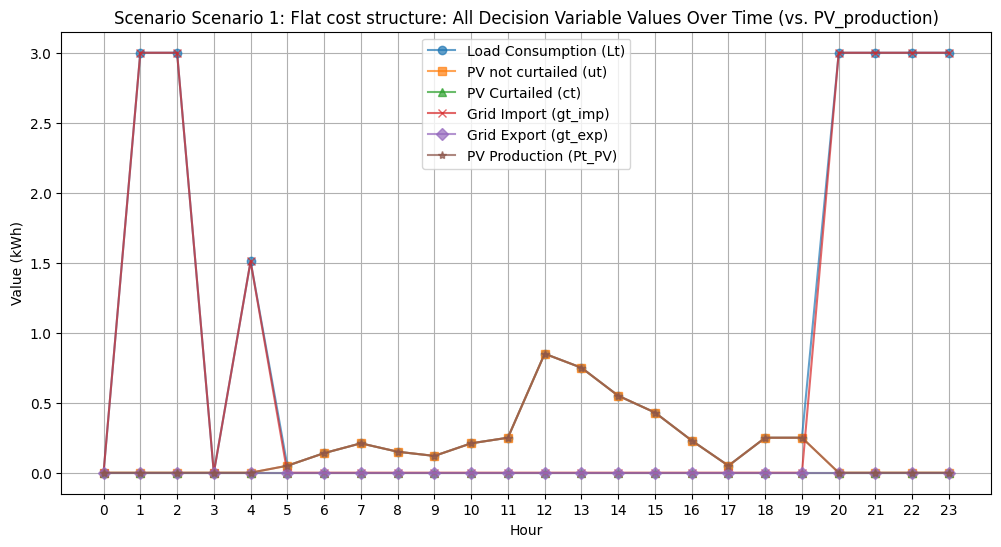

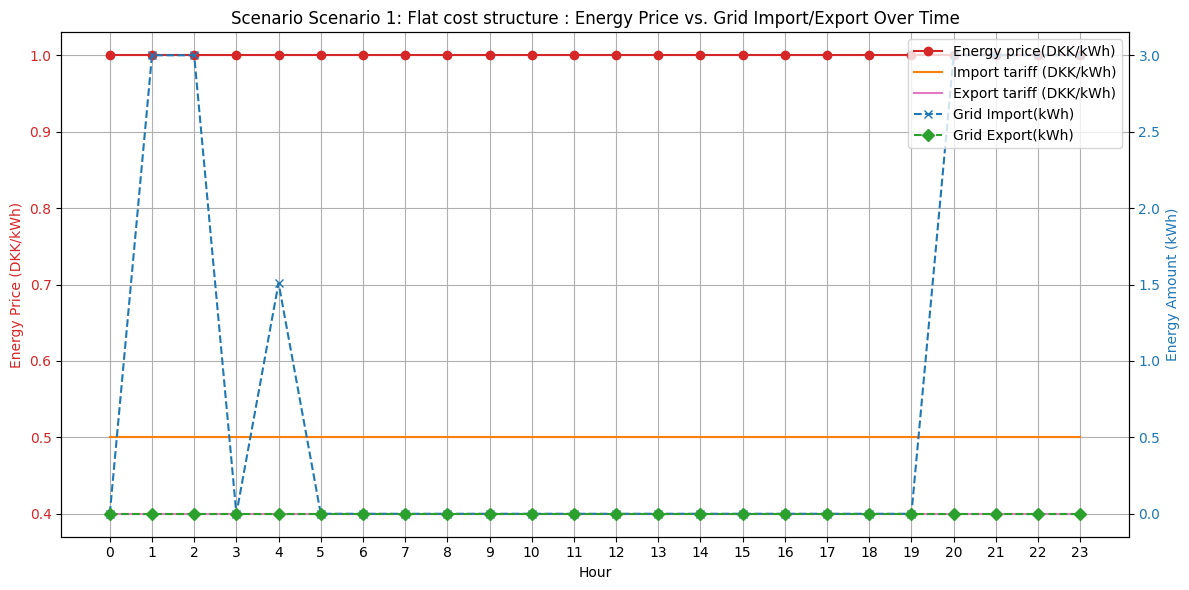


--- Running Scenario 2: High export penalty ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x30c2188d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 33 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8500000e+03   1.001842e+04   0.000000e+00      0s
       9    2.3413000e+01   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.341300000e+01
Optimization Scenario 2: High export penalty successful!
Optimal objective

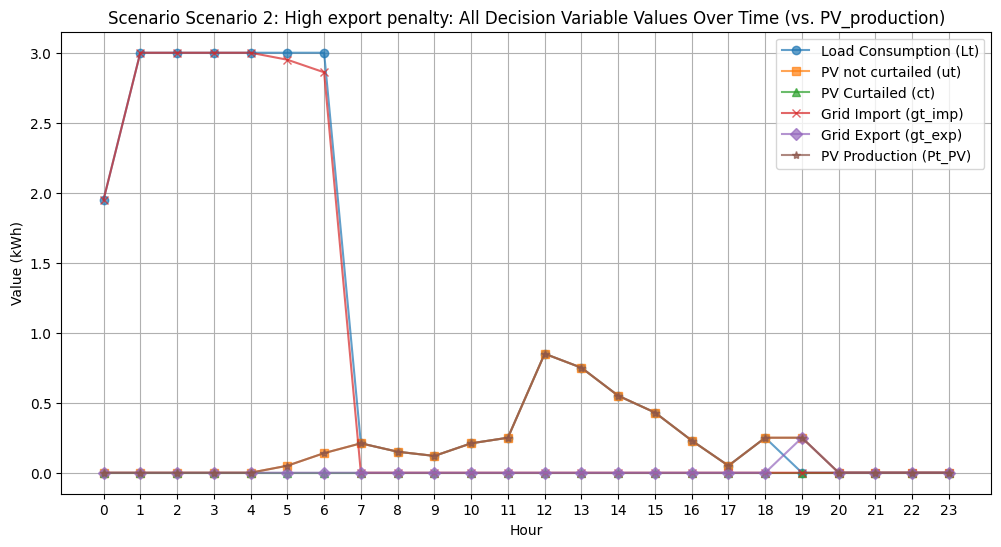

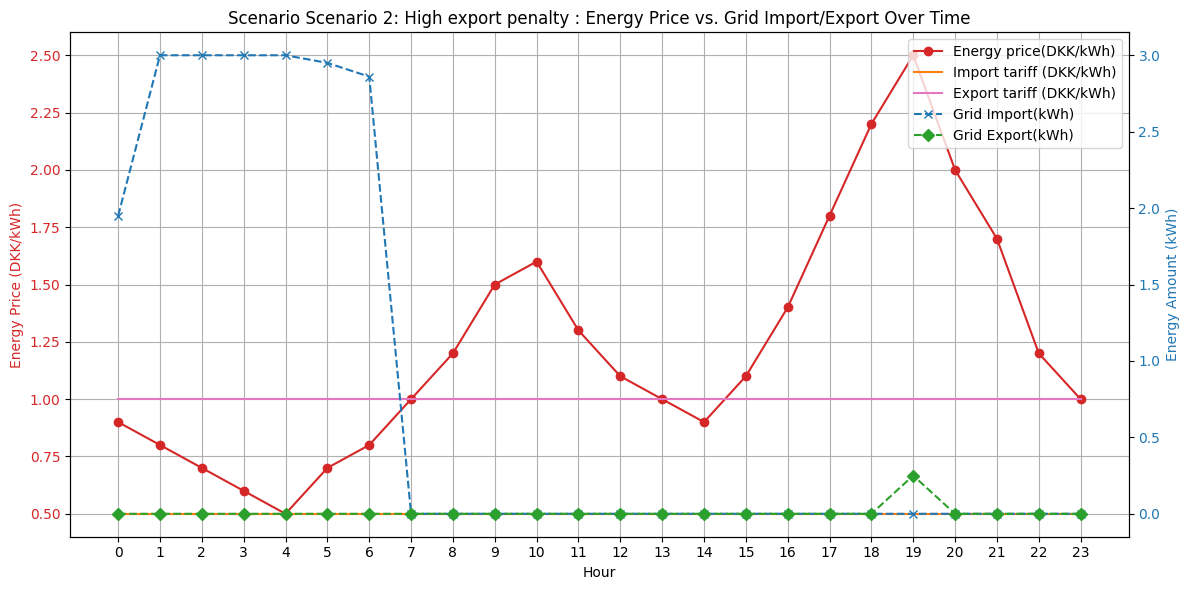


--- Running Scenario 3: Incentivize curtailment ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x059708d6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 39 rows and 85 columns
Presolve time: 0.00s
Presolved: 10 rows, 35 columns, 44 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1599000e+03   4.998700e+03   0.000000e+00      0s
      13   -1.0971000e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.097100000e+01
Optimization Scenario 3: Incentivize curtailment successful!
Optimal 

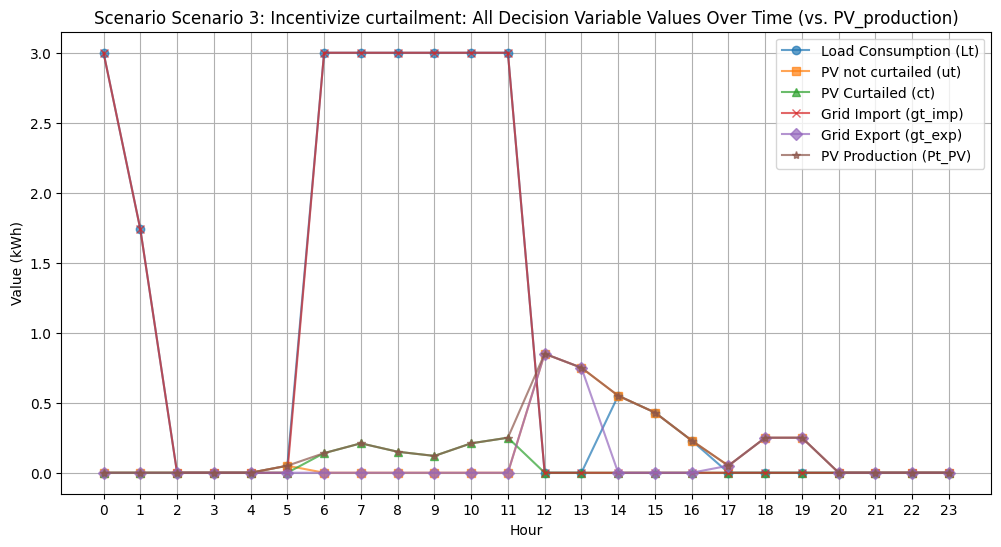

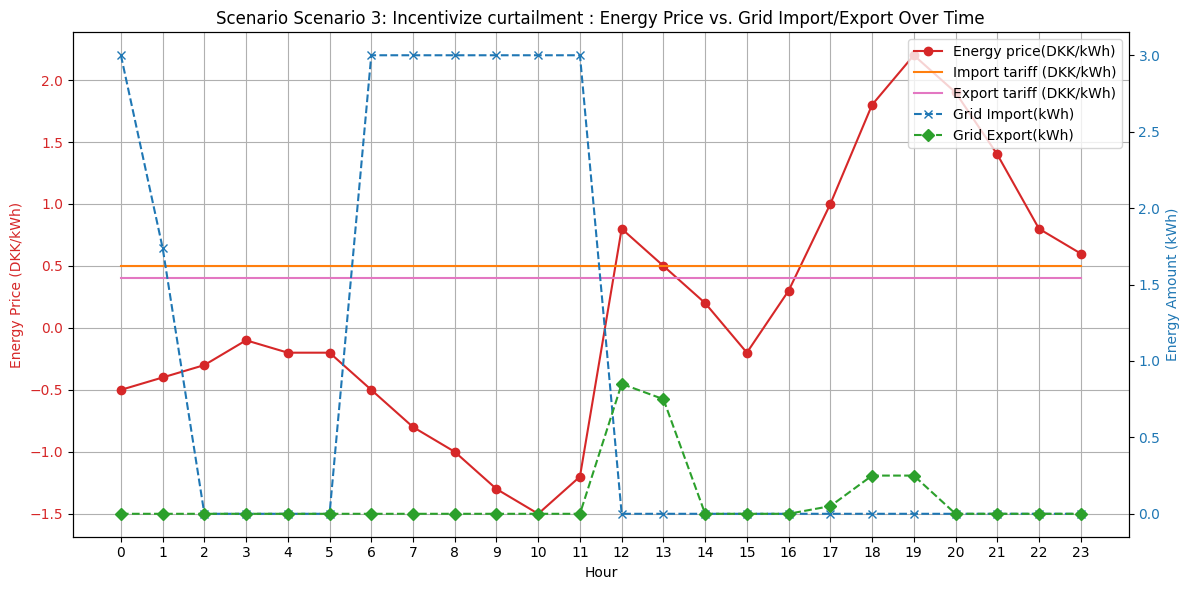


--- Running Scenario 4: No tariffs ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x54fd4eae
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 48 rows and 105 columns
Presolve time: 0.00s
Presolved: 1 rows, 15 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5375000e+00   1.200000e+01   0.000000e+00      0s
       1    1.7742500e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.774250000e+01
Optimization Scenario 4: No tariffs successful!
Optimal objective value: 17.7425000

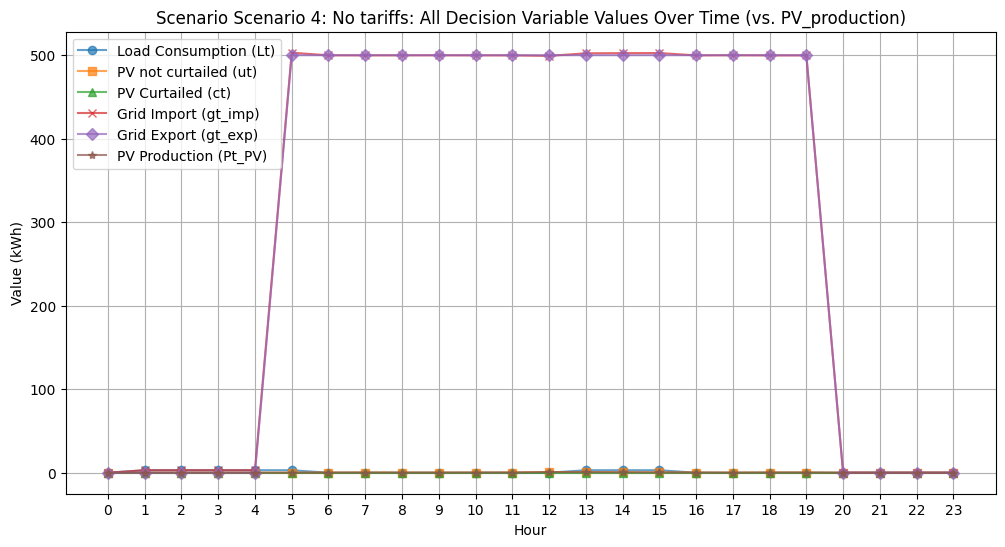

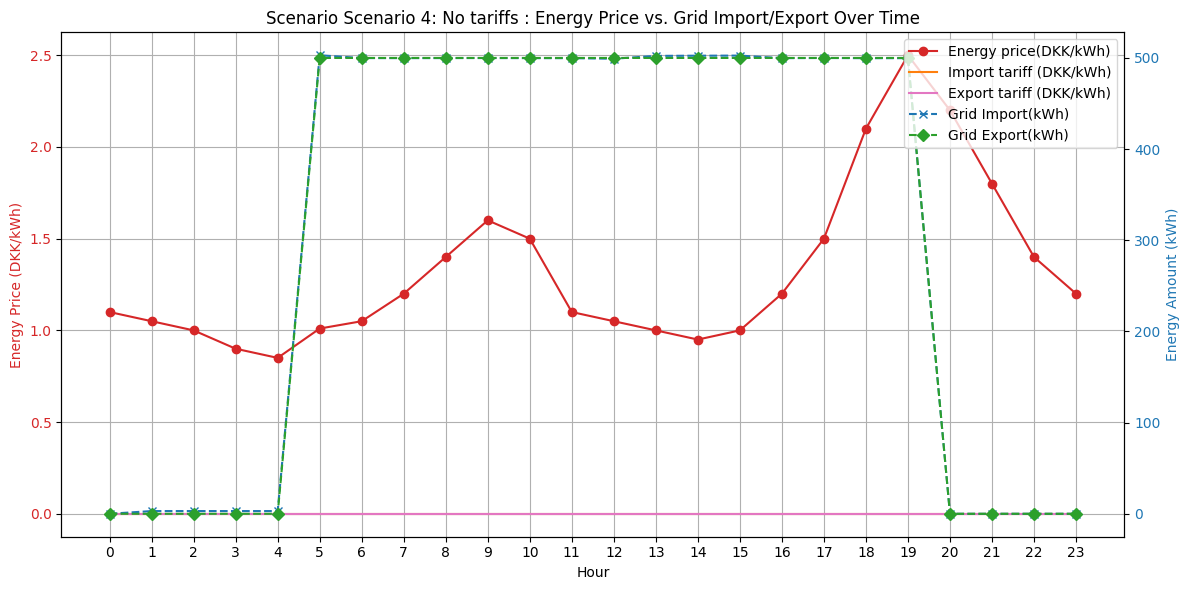

In [4]:
import json
import csv

# data from question 1a
with open('../data/question_1a/DER_production.json', 'r') as file:
    der_production = json.load(file)
with open('../data/question_1a/appliance_params.json', 'r') as file:
    appl_params= json.load(file)
with open('../data/question_1a/usage_preference.json', 'r') as file:
    usage_preference= json.load(file)

# Load all scenarios from one file
with open('../data/scenarios.json', 'r') as file:
    scenarios = json.load(file)

# Loop through each scenario
for i, scenario in enumerate(scenarios):
    
    print(f"\n--- Running {scenario['scenario']} ---")

    results = run_model(
        scenario = scenario["scenario"],  # use scenario name instead of just index
        Lmin_t = 0.0,
        Lmax_t = appl_params["load"][0]["max_load_kWh_per_hour"],
        Pt_PV = der_production[0]["hourly_profile_ratio"],
        ct_PV = 0,
        pt = scenario["energy_price_DKK_per_kWh"],  # hourly prices
        Emin = usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] 
             * appl_params["load"][0]["max_load_kWh_per_hour"],
        max_import_kW = scenario["max_import_kW"],
        max_export_kW = scenario["max_export_kW"],
        tau_imp = scenario["import_tariff_DKK/kWh"],
        tau_exp = scenario["export_tariff_DKK/kWh"],
    )